In [1]:

from geodude.utils import Paper, merge_LineStrings
import vsketch
import numpy as np
from shapely.geometry import (
    box, 
    MultiLineString, 
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString,
    )
%load_ext autoreload
%autoreload 2
from fn.fn import new_savepath
from geodude.ops import make_like
from shapely import is_valid, unary_union
import itertools
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from geodude.line import dash_linestring
from geodude.intersection import (
    pairwise_partition_polygons, 
    polys_to_gdf, 
    find_intersecting_polys,
    find_touching_polys, 
    find_clusters, 
    find_contained_polys, 
    find_parent_polygons,
    merge_disjoint_polys,
    assign_random_order_to_adjacent_clusters,
    assign_psuedoperiodic_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons
    )
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

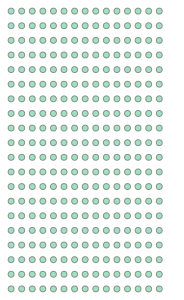

In [52]:
n_xs = 15
n_ys = 20
n_pts = n_xs * n_ys
xs = np.linspace(30, 190, n_xs)
ys = np.linspace(0, 300, n_ys)
pts = [Point(x, y) for x, y in itertools.product(xs, ys)]
radii = [np.interp(pt.y, [0, 150, 300], [1, 20, 1]) for pt in pts]
thicknesses = [np.interp(pt.y, [0, 150, 300], [0.3, 2, 0.3]) for pt in pts]

MultiPoint(pts)

In [53]:
circles = [p.buffer(r).boundary.buffer(thickness) for p,r, thickness in zip(pts, radii, thicknesses)]

In [54]:
gdf = polys_to_gdf(circles)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 300 polygons
2770 intersections remaining
Chunking polygons
Partitioning 21 chunks


21it [00:03,  5.72it/s]


Iteration 1 complete, 1397 polygons remaining
Iteration 2
Finding intersections in 1397 polygons
5590 intersections remaining
Chunking polygons
Partitioning 86 chunks


86it [00:07, 12.01it/s]


Iteration 2 complete, 2445 polygons remaining
Iteration 3
Finding intersections in 2445 polygons
7044 intersections remaining
Chunking polygons
Partitioning 169 chunks


169it [00:10, 16.47it/s]


Iteration 3 complete, 3425 polygons remaining
Iteration 4
Finding intersections in 3425 polygons
6458 intersections remaining
Chunking polygons
Partitioning 208 chunks


208it [00:10, 19.05it/s]


Iteration 4 complete, 3635 polygons remaining
Iteration 5
Finding intersections in 3635 polygons
4808 intersections remaining
Chunking polygons
Partitioning 197 chunks


197it [00:09, 20.50it/s]


Iteration 5 complete, 3008 polygons remaining
Iteration 6
Finding intersections in 3008 polygons
2940 intersections remaining
Chunking polygons
Partitioning 139 chunks


139it [00:05, 23.48it/s]


Iteration 6 complete, 1913 polygons remaining
Iteration 7
Finding intersections in 1913 polygons
1648 intersections remaining
Chunking polygons
Partitioning 86 chunks


86it [00:03, 25.62it/s]


Iteration 7 complete, 1096 polygons remaining
Iteration 8
Finding intersections in 1096 polygons
906 intersections remaining
Chunking polygons
Partitioning 50 chunks


50it [00:02, 22.33it/s]


Iteration 8 complete, 700 polygons remaining
Iteration 9
Finding intersections in 700 polygons
434 intersections remaining
Chunking polygons
Partitioning 30 chunks


30it [00:01, 25.27it/s]


Iteration 9 complete, 350 polygons remaining
Iteration 10
Finding intersections in 350 polygons
138 intersections remaining
Chunking polygons
Partitioning 10 chunks


10it [00:00, 26.01it/s]


Iteration 10 complete, 110 polygons remaining
Iteration 11
Finding intersections in 110 polygons
44 intersections remaining
Chunking polygons
Partitioning 3 chunks


3it [00:00, 21.42it/s]


Iteration 11 complete, 38 polygons remaining
Iteration 12
Finding intersections in 38 polygons
14 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 23.70it/s]

Iteration 12 complete, 15 polygons remaining
Iteration 13
Finding intersections in 15 polygons
0 intersections remaining
Chunking polygons


In [55]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)
ngdf = merge_disjoint_polys(disjoint)

# clean up with closing + opening
buffer_value = 0.1
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False)


In [78]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-6) & ~ngdf.is_empty & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



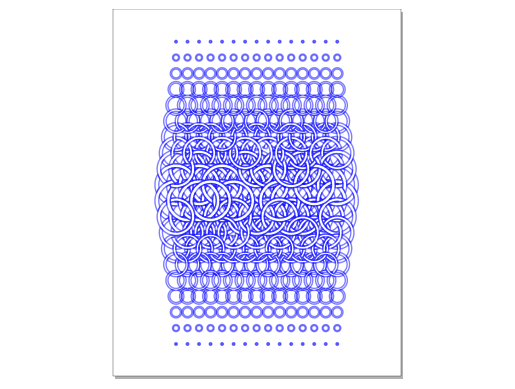

In [57]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
mls = make_like(mls, drawbox)
sk.geometry(mls)
sk.display()


In [79]:
middle_circle = Point(110, 150).buffer(50)
middle_lines = mls.intersection(middle_circle)

In [80]:
outer_lines = mls.difference(middle_circle)

In [ ]:
def generate_interpolation_dists(dist_gen):
    max_value = 0
    values = []
    while max_value < 1:
        delta = dist_gen.rvs()
        dist = max_value + delta
        if dist > 1:
            break
        values.append(dist)
        max_value = dist
    return np.array(values)

In [90]:

breakpoint_sets = [np.sort(np.random.uniform(0, 1, 5)) for _ in range(len(middle_lines.geoms))]
dashed_lines = [dash_linestring(ls, breakpoints) for ls, breakpoints in zip(middle_lines.geoms, breakpoint_sets)]
dashed_lines = merge_LineStrings(dashed_lines)

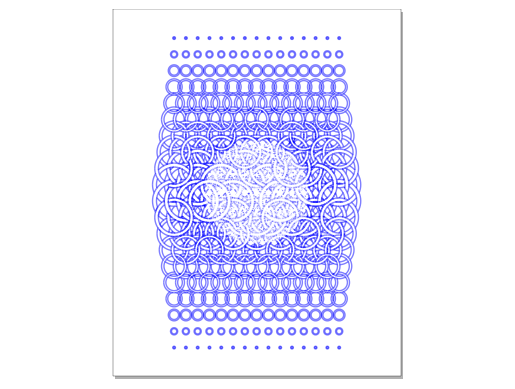

In [91]:

dashed_mls = merge_LineStrings([dashed_lines, outer_lines])
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(dashed_mls)
sk.display()

In [92]:
fp = new_savepath(postfix='gap_in_the_tangle')
sk.save(fp)